In [56]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torchaudio
# from encodec import EncodecModel
from tqdm import  tqdm
from torchvision import transforms
from IPython.display import FileLink
import random

In [57]:
train_data_path = "/u/li19/data_folder/AudioTaggingDoneRight/egs/audioset/data/datafiles/delta_bal_alpaca_train.json"
with open(train_data_path, 'r') as f:
    train_data = json.load(f)["data"]
print(len(train_data))

21717


In [58]:
device = 'cuda'

In [246]:
keyword = 'bird'

In [247]:
sample_list = []
for i,entry in enumerate(train_data):
    # if i> 200:
    #     break
    youtube_id = entry['wav'].split('.')[0][-11:]
    if keyword in [ent.lower() for ent in entry['classes']]:
        print(youtube_id, entry['classes'], entry['caption'])
        sample_list.append(youtube_id)

-aC8TJIZrtE ['Bird', 'Bird vocalization, bird call, bird song', 'Fowl', 'Crowing, cock-a-doodle-doo', 'Cluck', 'Chicken, rooster']  a chicken crowing, a bird singing, 2 bird calls, a fowl, and a cock-a-doodle-doo.
-kBZeTTEOGc ['Bird', 'Bird vocalization, bird call, bird song', 'Coo', 'Pigeon, dove']  A bird singing, bird call, pigeon cooing and doves calling. 
07vCFDpflcQ ['Bird', 'Duck']  A bird and a duck chirping and quacking simultaneously.
0aKuES6SO2k ['Bird', 'Bird vocalization, bird call, bird song', 'Chirp, tweet']  A bird chirping, tweeting and singing with a bird call and a human speech. 
0kuZvI5eQwg ['Bird', 'Bird vocalization, bird call, bird song', 'Coo', 'Pigeon, dove']  different bird sounds, including bird vocalization, bird call, bird song, cooing, and pigeon dove. 
1E_3Grl-3PA ['Bird', 'Bird vocalization, bird call, bird song', 'Coo', 'Pigeon, dove']  A bird singing, cooing and doving.
1IFfUjdN91k ['Bird', 'Bird vocalization, bird call, bird song', 'Chirp, tweet', 'Co

In [248]:
random_number = random.randint(1, 50)
sample_youtube_id = sample_list[random_number]
print(sample_youtube_id)

9KD9_wsWudk


In [249]:
youtube_id = sample_youtube_id
wav_folder = "/u/li19/data_folder/audioSetAudio/unbalanced_wav"
wav, sr = torchaudio.load(os.path.join(wav_folder, youtube_id+'.wav'))
wav = wav - wav.mean()
wav=wav.to(device)
print(wav.shape)

torch.Size([1, 160000])


In [250]:
final = wav[0].cpu()

In [251]:
ipd.Audio(wav.cpu(), rate=16_000)

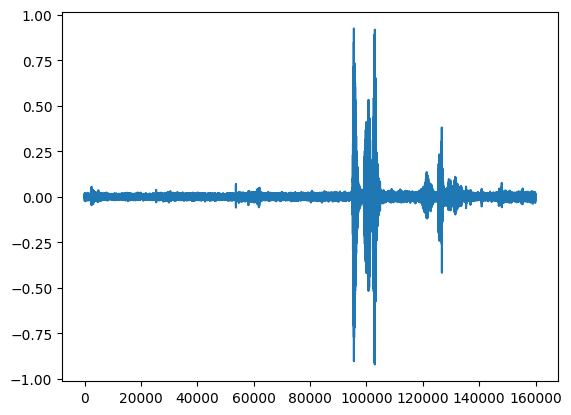

In [252]:
plt.plot(wav[0].cpu().numpy())


In [253]:
n_fft = 4096
win_length = 1024
hop_length = 400
n_mels = 64
sample_rate = 16000

waveform = torch.from_numpy(np.copy(final)[None, :])
waveform_orgin = wav.detach().cpu()
print(waveform.shape)

mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="constant",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="slaney",
)

# From latent file in dataset
mel_spectrogram = mel_spectrogram_transform(waveform)
amplitude_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=88)
log_mel_spectrogram_db = amplitude_to_db_transform(mel_spectrogram)


# From wav file
mel_spectrogram_orig = mel_spectrogram_transform(waveform_orgin)
log_mel_spectrogram_db_orig = amplitude_to_db_transform(mel_spectrogram_orig)
# log_mel_spectrogram_db = log_mel_spectrogram_db.transpose(0,1)

torch.Size([1, 160000])


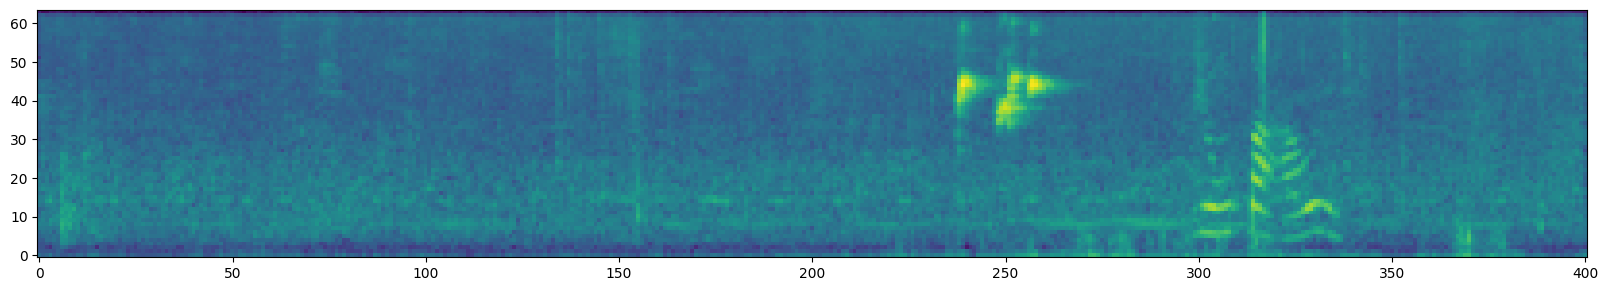

/u/li19/diffusers_with_dataloader/notebooks/imgs/spec-9KD9_wsWudk.png

In [254]:
# Set the figure size
fig= plt.figure(figsize=(20, 10))
# Show the image
plt.imshow(log_mel_spectrogram_db[0], origin='lower')
filename = f'imgs/spec-{youtube_id}.png'
plt.savefig(filename)
# plt.colorbar()
# Display the plot
plt.show()
plt.close()
display(FileLink(filename))


# Torch implementation of Yin

In [255]:
import torchyin

In [256]:
print(wav[0].shape)

torch.Size([160000])


In [257]:
FS = 16000

In [258]:
y = torch.sin(2 * torch.pi * 440 / FS * torch.arange(FS))
print(y.shape)

torch.Size([16000])


In [259]:
pitch = torchyin.estimate(wav[0], sample_rate=16000)


In [260]:
PITCHES = [261.63, 293.66, 329.63, 349.23, 392.00, 440.00, 493.88]

f = np.repeat(PITCHES, FS // 2 // len(PITCHES) + 1)
y = np.sin(2 * np.pi * (np.cumsum(f / FS) % 1.0))

p = torchyin.estimate(y, sample_rate=FS, pitch_min=200, frame_stride=0.01)

ipd.Audio(y, rate=FS)

In [261]:
print(p)

tensor([262.2951, 262.2951, 262.2951, 262.2951, 262.2951, 262.2951, 262.2951,
        290.9091, 296.2963, 296.2963, 296.2963, 296.2963, 296.2963, 296.2963,
        320.0000, 326.5306, 326.5306, 326.5306, 326.5306, 326.5306, 326.5306,
        340.4255, 347.8261, 347.8261, 347.8261, 347.8261, 347.8261, 347.8261,
        363.6364, 390.2439, 390.2439, 390.2439, 390.2439, 390.2439, 390.2439,
        400.0000, 444.4444, 444.4444, 444.4444, 444.4444, 444.4444, 444.4444,
        444.4444, 500.0000, 500.0000, 500.0000, 500.0000, 500.0000, 500.0000,
        500.0000], dtype=torch.float64)


In [262]:
print(pitch)

tensor([   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.000

In [263]:
print(pitch.shape)

torch.Size([991])


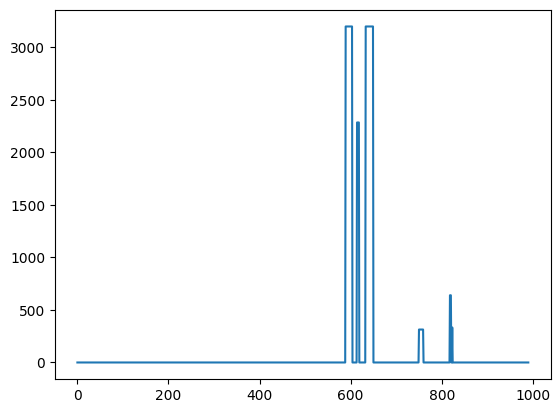

In [264]:
plt.plot(pitch.squeeze().cpu())

# Torchaudio's implementation

In [265]:
import torchaudio.functional as F
import torchaudio.transforms as T

In [266]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [267]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
    if num_channels > 1:
        axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
        axes[c].set_xlim(xlim)
    if ylim:
        axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [268]:
def plot_pitch(waveform, sample_rate, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time,  waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

    axis2.legend(loc=0)
    plt.show(block=False)

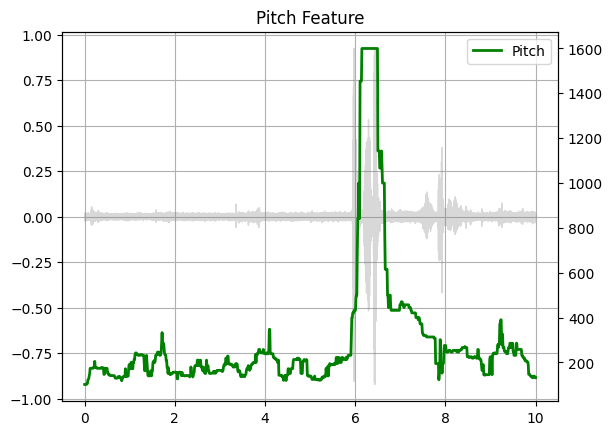

In [269]:

pitch = F.detect_pitch_frequency(wav.cpu(), sr)
plot_pitch(wav.cpu().numpy(), sr, pitch)
ipd.Audio(wav.cpu(), rate=sr)

In [270]:
print(pitch.shape)

torch.Size([1, 985])


# Torchaudio's replica of Kaldi

In [271]:
def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Kaldi Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sample_rate
    time_axis = torch.linspace(0, end_time,  waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
    axis.set_ylim((-1.3, 1.3))

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, nfcc.shape[1])
    ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    axis.legend(lns, labels, loc=0)
    plt.show(block=False)

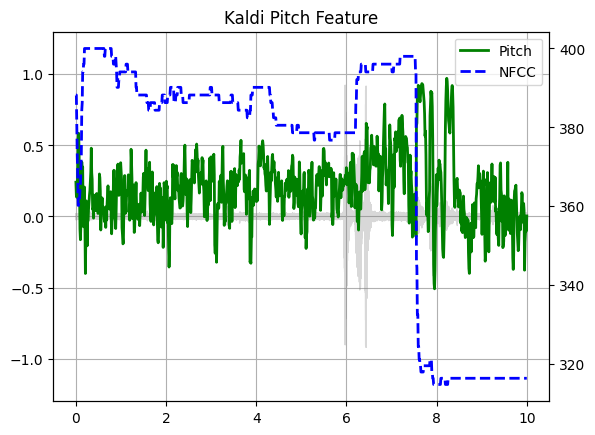

In [272]:
pitch_feature = F.compute_kaldi_pitch(wav.cpu(), sample_rate)
pitch, nfcc = pitch_feature[..., 0], pitch_feature[..., 1]

plot_kaldi_pitch(wav.cpu(), sr, pitch, nfcc)


In [273]:
print(pitch.shape)

torch.Size([1, 998])


# Formants

In [314]:
import parselmouth
from parselmouth.praat import call

# Load sound file
sound = parselmouth.Sound(os.path.join(wav_folder, youtube_id+'.wav'))

# Perform formant extraction
formant = call(sound, "To Formant (burg)", 0.0025, 5, 8000, 0.025, 50)



In [315]:
print(formant)

Object type: Formant
Object name: untitled
Date: Thu Jun  8 10:53:00 2023

Time domain:
   Start time: 0 seconds
   End time: 10 seconds
   Total duration: 10 seconds
Time sampling:
   Number of frames: 3980
   Time step: 0.0025 seconds
   First frame centred at: 0.026249999999999957 seconds



In [316]:
# Get formants for the midpoint of the sound file
time_step = 0.05
times = np.arange(0, sound.duration, time_step)  # Array of time points
mid_point = sound.xs()[int(len(sound.xs()) / 2)]
f1 = call(formant, "Get value at time", 1, mid_point, 'Hertz', 'Linear')
f2 = call(formant, "Get value at time", 2, mid_point, 'Hertz', 'Linear')
f3 = call(formant, "Get value at time", 3, mid_point, 'Hertz', 'Linear')

print('F1: ', f1)
print('F2: ', f2)
print('F3: ', f3)

F1:  1511.5113692624516
F2:  2753.892922682884
F3:  4265.015202034343


In [317]:
formants = np.zeros((3, len(times)))

for i, t in enumerate(times):
    f1 = call(formant, "Get value at time", 1, t, 'Hertz', 'Linear')
    f2 = call(formant, "Get value at time", 2, t, 'Hertz', 'Linear')
    f3 = call(formant, "Get value at time", 3, t, 'Hertz', 'Linear')

    formants[0, i] = f1
    formants[1, i] = f2
    formants[2, i] = f3

# Now formants is a 3*t matrix of formant frequencies over time
print(formants)

[[          nan 1132.65610587 1162.44693694  811.21893272  910.26040224
  1114.86988708 1164.02010787 1245.07708604 1117.60951583 1107.98826429
   990.8212326  1127.47298117 1354.43525731 1125.07926336 1073.58151786
  1098.07775604 1128.32608487 1092.14350939 1123.3549106  1171.06147394
  1066.11191309 1278.53069121 1207.93475306 1163.36006075 1195.28487869
  1038.28769296 1155.19916067  961.52798914 1063.2859149  1335.96785718
  1148.65769882 1097.88202696 1299.28490555 1343.52562553 1626.72492127
  1140.88091462 1162.28679945 1150.64414876 1216.96309889  989.12747382
   889.48369436 1040.34351349 1136.33497537 1081.16369466 1447.6000452
  1087.7272545  1233.32997597 1071.37226704 1424.15796858 1401.16852242
  1076.59576713 1057.38213889 1124.00555478 1051.43797398 1199.61677606
  1167.49077693 1303.42182168 1141.14670186 1045.54255187  934.68355233
  1076.79200694 1108.28285027 1331.22061833 1186.00233087 1068.19895515
  1133.59597109 1091.63873334 1331.85254764 1336.80211262 1107.46

In [318]:
print(formants.shape)

(3, 200)


In [319]:
print(formants[0])

[          nan 1132.65610587 1162.44693694  811.21893272  910.26040224
 1114.86988708 1164.02010787 1245.07708604 1117.60951583 1107.98826429
  990.8212326  1127.47298117 1354.43525731 1125.07926336 1073.58151786
 1098.07775604 1128.32608487 1092.14350939 1123.3549106  1171.06147394
 1066.11191309 1278.53069121 1207.93475306 1163.36006075 1195.28487869
 1038.28769296 1155.19916067  961.52798914 1063.2859149  1335.96785718
 1148.65769882 1097.88202696 1299.28490555 1343.52562553 1626.72492127
 1140.88091462 1162.28679945 1150.64414876 1216.96309889  989.12747382
  889.48369436 1040.34351349 1136.33497537 1081.16369466 1447.6000452
 1087.7272545  1233.32997597 1071.37226704 1424.15796858 1401.16852242
 1076.59576713 1057.38213889 1124.00555478 1051.43797398 1199.61677606
 1167.49077693 1303.42182168 1141.14670186 1045.54255187  934.68355233
 1076.79200694 1108.28285027 1331.22061833 1186.00233087 1068.19895515
 1133.59597109 1091.63873334 1331.85254764 1336.80211262 1107.4670266
 1127.47

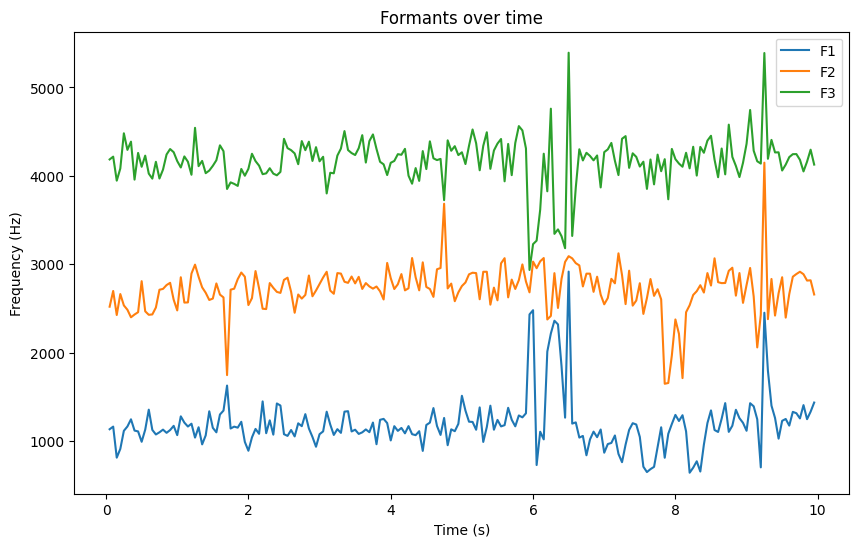

In [320]:
plt.figure(figsize=(10, 6))
plt.plot(times, formants[0, :], label='F1')
plt.plot(times, formants[1, :], label='F2')
plt.plot(times, formants[2, :], label='F3')
plt.title('Formants over time')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

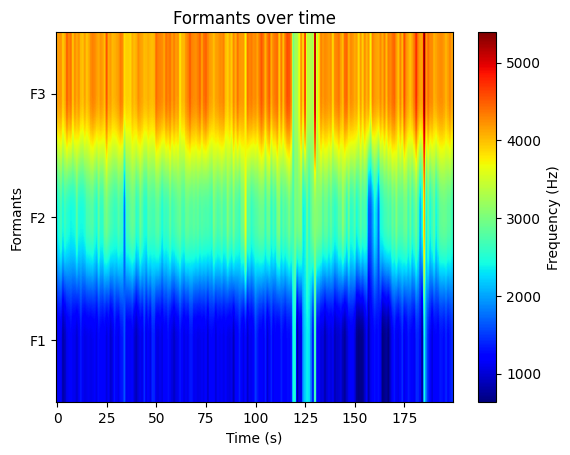

In [321]:
from scipy import interpolate
for i in range(3):
    valid_mask = np.isfinite(formants[i, :])
    times_valid = times[valid_mask]
    formants_valid = formants[i, valid_mask]

    f = interpolate.interp1d(times_valid, formants_valid, bounds_error=False, fill_value="extrapolate")
    formants[i, :] = f(times)

# Display formants as an image
plt.imshow(formants, aspect='auto', cmap='jet', origin='lower')
plt.colorbar(label='Frequency (Hz)')
plt.yticks([0, 1, 2], ['F1', 'F2', 'F3'])
plt.xlabel('Time (s)')
plt.ylabel('Formants')
plt.title('Formants over time')
plt.show()


In [290]:
print(formants.shape)

(3, 1000)
